In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(device)

In [1]:
# run this cell if on mac

import torch

# mps runs out of memory without batches, and neighbor batches aren't supported on mac yet
device = torch.device('cpu')

In [2]:
import pandas as pd
from pathlib import Path

# get data (need git LFS)
node_path = Path("dataset") / "HI-Small_accounts.csv"
edge_path = Path("dataset") / "HI-Small_Trans.csv"
node_data = pd.read_csv(node_path)
edge_data = pd.read_csv(edge_path)

In [3]:
import numpy as np

# use indices from accounts dataset for node indices
accounts = node_data.reset_index()[['Account Number', 'index']]
num_nodes = accounts.shape[0]
compact = {accounts['Account Number'][i]: accounts['index'][i] for i in range(num_nodes)}
to_node = np.vectorize(lambda x: compact[x])

In [4]:
from torch_geometric.data import Data

# create adjacency list in COO format
source = to_node(edge_data['Account'])
target = to_node(edge_data['Account.1'])
edge_index = torch.from_numpy(np.vstack([source, target])).to(device)

edge_pairs = torch.transpose(edge_index, 0, 1)
num_edges = edge_index.shape[1]

g = Data(edge_index=edge_index, num_nodes=num_nodes)

In [5]:
from torch_geometric.utils import degree
import torch.nn.functional as F
from sklearn.preprocessing import OneHotEncoder

# create bank frequency column
freq = node_data['Bank ID'].value_counts()
id_freq = np.vectorize(lambda x: freq[x])
node_data['Bank Frequency'] = id_freq(node_data['Bank ID'])
node_data['Bank Frequency'] = pd.cut(node_data['Bank Frequency'], bins=[0, 2, 10, 100, 4000], labels=[0, 1, 2, 3])

# use one hot encoding for categorical variables
bank_enc = OneHotEncoder(sparse_output=False)
bank_frequency = bank_enc.fit_transform(node_data['Bank Frequency'].to_numpy().reshape(-1, 1))

paid_enc = OneHotEncoder(sparse_output=False)
currency_sent = paid_enc.fit_transform(edge_data['Payment Currency'].to_numpy().reshape(-1, 1))

received_enc = OneHotEncoder(sparse_output=False)
currency_received = received_enc.fit_transform(edge_data['Receiving Currency'].to_numpy().reshape(-1, 1))

format_enc = OneHotEncoder(sparse_output=False)
pay_format = format_enc.fit_transform(edge_data['Payment Format'].to_numpy().reshape(-1, 1))

# create numerical variables
time_trans = pd.to_datetime(edge_data['Timestamp']).astype('int64') / 1e9
amount_sent = edge_data['Amount Paid'].to_numpy()
amount_received = edge_data['Amount Received'].to_numpy()

# combine all edge features into one tensor with dtype = float32
edge_features = torch.from_numpy(np.column_stack([time_trans, amount_received,
                                                  currency_received, pay_format])).float().to(device)
edge_dim = edge_features.shape[1]

# edge label with 0 = not laundering, 1 = is laundering
label = torch.from_numpy(edge_data['Is Laundering'].to_numpy()).long().to(device)

g.x = torch.from_numpy(bank_frequency).float().to(device)
g.edge_attr = F.normalize(edge_features)
g.edge_label = label

In [6]:
# chronological 60/20/20 split

train_end = int(0.6 * num_edges)
val_end = int(0.8 * num_edges)

train_idx = torch.zeros(num_edges, dtype=torch.bool)
train_idx[:train_end] = True

val_idx = torch.zeros(num_edges, dtype=torch.bool)
val_idx[train_end:val_end] = True

test_idx = torch.zeros(num_edges, dtype=torch.bool)
test_idx[val_end:] = True

g.train_mask = train_idx
g.val_mask = val_idx
g.test_mask = test_idx

In [7]:
# hyperparameters

epochs = 10

pos_weight = 10

embedding_dim = 64

hidden = 64

learn_rate = 0.005

dropout = 0.5

In [8]:
from torch_geometric.nn import GINEConv
import torch.nn as nn

# node embedding model
class GNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, embedding_dim, edge_feat_dim, dropout):
        super().__init__()        
        self.in_channels = in_channels
        self.hidden = hidden_channels
        self.dim = embedding_dim
        self.edge_dim = edge_feat_dim
        self.drop = dropout
        
        # linear embeddings
        self.node_embedding = nn.Linear(self.in_channels, self.dim)
        self.edge_embedding = nn.Linear(self.edge_dim, self.dim)
        
        # convolution layers for node embedding
        self.conv1 = GINEConv(nn.Sequential(
                    nn.Linear(self.dim, self.dim),
                    nn.ReLU(),
                    nn.Linear(self.dim, self.dim)
                    ), edge_dim=self.dim)
        self.conv2 = GINEConv(nn.Sequential(
                    nn.Linear(self.dim, self.dim),
                    nn.ReLU(),
                    nn.Linear(self.dim, self.dim)
                    ), edge_dim=self.dim)
        
        # mlp for edge embedding
        self.mlp_edge = nn.Sequential(
            nn.Linear(self.dim*3, self.dim),
            nn.ReLU(),
            nn.Linear(self.dim, self.dim),
        )
        
        # mlp for edge classifier
        self.mlp_classifier = nn.Sequential(
            nn.Linear(self.dim*3, self.hidden),
            nn.ReLU(),
            nn.Dropout(self.drop),
            nn.Linear(self.hidden, self.hidden // 2),
            nn.ReLU(),
            nn.Dropout(self.drop),
            nn.Linear(self.hidden // 2, 2)
        )
        
    def forward(self, x, edge_index, edge_attr):
        u, v = edge_index
        x = self.node_embedding(x)
        edge_attr = self.edge_embedding(edge_attr)
        
        # message passing with averaging aggregation method
        x = 0.5 * (x + F.relu(self.conv1(x, edge_index, edge_attr)))
        edge_attr = edge_attr + 0.5*self.mlp_edge(torch.cat([x[u], x[v], edge_attr], dim=-1))
        
        x = 0.5 * (x + F.relu(self.conv2(x, edge_index, edge_attr)))
        edge_attr = edge_attr + 0.5*self.mlp_edge(torch.cat([x[u], x[v], edge_attr], dim=-1))
        
        # combine embedding of source, target, and edge features
        x = x[edge_pairs].reshape(-1, 2*self.dim).relu()
        return self.mlp_classifier(torch.cat([x, edge_attr], dim=1))

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score

# evaluate performance
def evaluate(split_idx):
    gnn.eval()
    with torch.no_grad():
        logits = gnn(g.x, g.edge_index, g.edge_attr)
        y = g.edge_label
        preds = logits.argmax(dim=-1)
        accuracy = accuracy_score(y, preds)
        precision = precision_score(y, preds, zero_division=0.0)
        recall = recall_score(y, preds, zero_division=0.0)
        f1 = f1_score(y, preds, zero_division=0.0)
        return [accuracy, precision, recall, f1]

def plots(split_idx):
    gnn.eval()
    with torch.no_grad():
        logits = gnn(g.x, g.edge_index, g.edge_attr)
        y = g.edge_label
        preds = logits.argmax(dim=-1)
        cm = confusion_matrix(y, preds)
        
        # plot confusion matrix for default threshold
        plt.figure(1)
        ConfusionMatrixDisplay(cm).plot() 
        plt.title('Confusion Matrix')
        plt.show()
        
        # plot loss curve
        plt.figure(2)
        plt.plot(loss_values)
        plt.xticks(range(0,epochs))
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Validation Loss')
        plt.show()
        
        # plot precision-recall curve 
        plt.figure(3)
        precision, recall, thresholds = precision_recall_curve(y, logits[:, 1])
        plt.plot(recall, precision, label=f'Precision-Recall Curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.show()

Epoch 01 | loss 0.5641 | accuracy 0.9990 | precision 0.0000| recall 0.0000| f1 0.0000
Epoch 02 | loss 0.2218 | accuracy 0.9990 | precision 0.0000| recall 0.0000| f1 0.0000
Epoch 03 | loss 0.2225 | accuracy 0.9990 | precision 0.0000| recall 0.0000| f1 0.0000
Epoch 04 | loss 0.1802 | accuracy 0.9990 | precision 0.0000| recall 0.0000| f1 0.0000
Epoch 05 | loss 0.1335 | accuracy 0.9990 | precision 0.0000| recall 0.0000| f1 0.0000
Epoch 06 | loss 0.1126 | accuracy 0.9990 | precision 0.0000| recall 0.0000| f1 0.0000
Epoch 07 | loss 0.0957 | accuracy 0.9990 | precision 0.0000| recall 0.0000| f1 0.0000
Epoch 08 | loss 0.0789 | accuracy 0.9990 | precision 0.0000| recall 0.0000| f1 0.0000
Epoch 09 | loss 0.0746 | accuracy 0.9990 | precision 0.0000| recall 0.0000| f1 0.0000
Epoch 10 | loss 0.0739 | accuracy 0.9990 | precision 0.0000| recall 0.0000| f1 0.0000


Test Accuracy: 0.9990
Test Precision: 0.0000
Test Recall: 0.0000
Test f1: 0.0000


<Figure size 640x480 with 0 Axes>

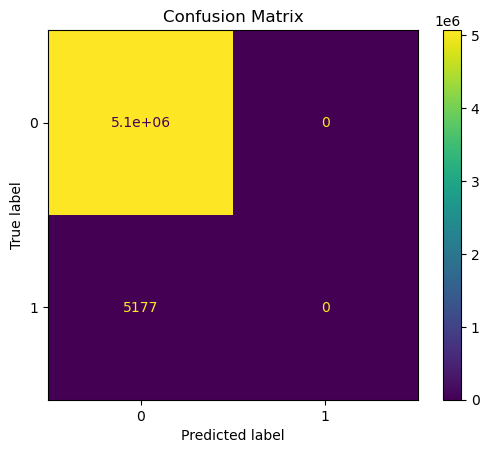

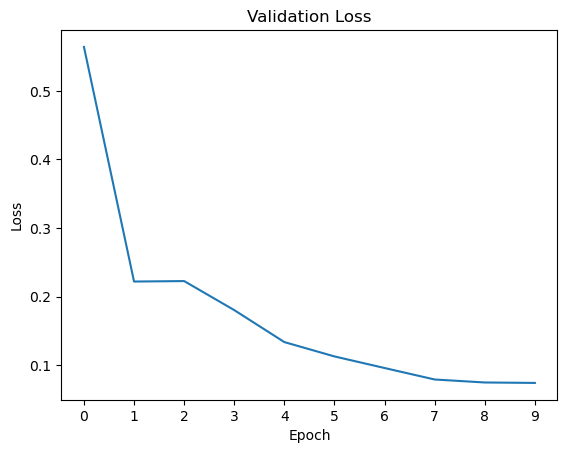

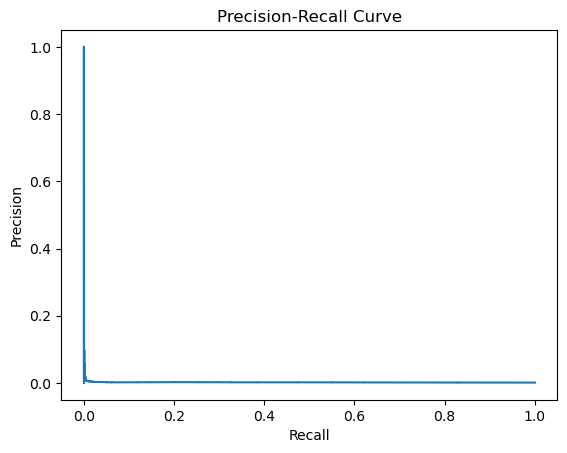

In [10]:
import torch.optim as optim

# instantiate model
gnn = GNN(4, hidden, embedding_dim, edge_dim, dropout).to(device)
weight = torch.tensor([1, pos_weight]).float().to(device)
optimizer = optim.Adam(gnn.parameters(), lr=learn_rate)
criterion = nn.CrossEntropyLoss(weight=weight).to(device)
        
# training loop
loss_values = []
for epoch in range(epochs):
    gnn.train()
    optimizer.zero_grad()
    logits = gnn(g.x, g.edge_index, g.edge_attr)
    loss = criterion(logits[train_idx], g.edge_label[train_idx])
    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())
    val_metrics = evaluate(val_idx)
    print(f'Epoch {epoch+1:02d} | loss {loss.item():.4f} | accuracy {val_metrics[0]:.4f} | precision {val_metrics[1]:.4f}| recall {val_metrics[2]:.4f}| f1 {val_metrics[3]:.4f}')

# evaluate metrics on test data
test_metrics = evaluate(test_idx)
print('\n')
print(f'Test Accuracy: {test_metrics[0]:.4f}')
print(f'Test Precision: {test_metrics[1]:.4f}')
print(f'Test Recall: {test_metrics[2]:.4f}')
print(f'Test f1: {test_metrics[3]:.4f}')

plots(test_idx)